In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [47]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\数据-时间戳.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='Sheet4') 
# print(df_sheet.info())
print(df_sheet.columns)





Index(['P插补', 'SI插补', '铁口1温度插补', '主参数时间戳', '富氧率', '透气性指数', 'CO', 'H2', 'CO2',
       '标准风速', '富氧流量', '冷风流量', '鼓风动能', '炉腹煤气量', '炉腹煤气指数', '理论燃烧温度', '顶压',
       '富氧压力', '冷风压力', '全压差', '热风压力', '实际风速', '热风温度', '顶温东北', '顶温西南', '顶温西北',
       '顶温东南', '阻力系数', '鼓风湿度', '设定喷煤量', '上小时喷煤量'],
      dtype='object')


In [49]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风温度', '设定喷煤量']
output_term = ['铁口1温度插补', 'SI插补']
time_term= '主参数时间戳'


In [50]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()

# 定义一个函数，用中位数替换异常值
def replace_outliers_with_median(series):
    # 计算列的中位数
    median_value = series.median()
    # 检测异常值
    outliers = (series - median_value).abs() > 3.0 * series.std()  # 使用标准差作为阈值
    # 使用中位数替换异常值
    series[outliers] = median_value
# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# replace_outliers_with_median(df_sheet_process[input_term[0]])
# replace_outliers_with_median(df_sheet_process[input_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[0]])
# replace_outliers_with_median(df_sheet_process[output_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[2]])
# replace_outliers_with_median(df_sheet_process[output_term[3]])

# plt.figure(figsize=(15, 10))
# for idx, column in enumerate(input_term+output_term):
    
#     plt.subplot(len(input_term+output_term), 1, idx+1)
#     plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




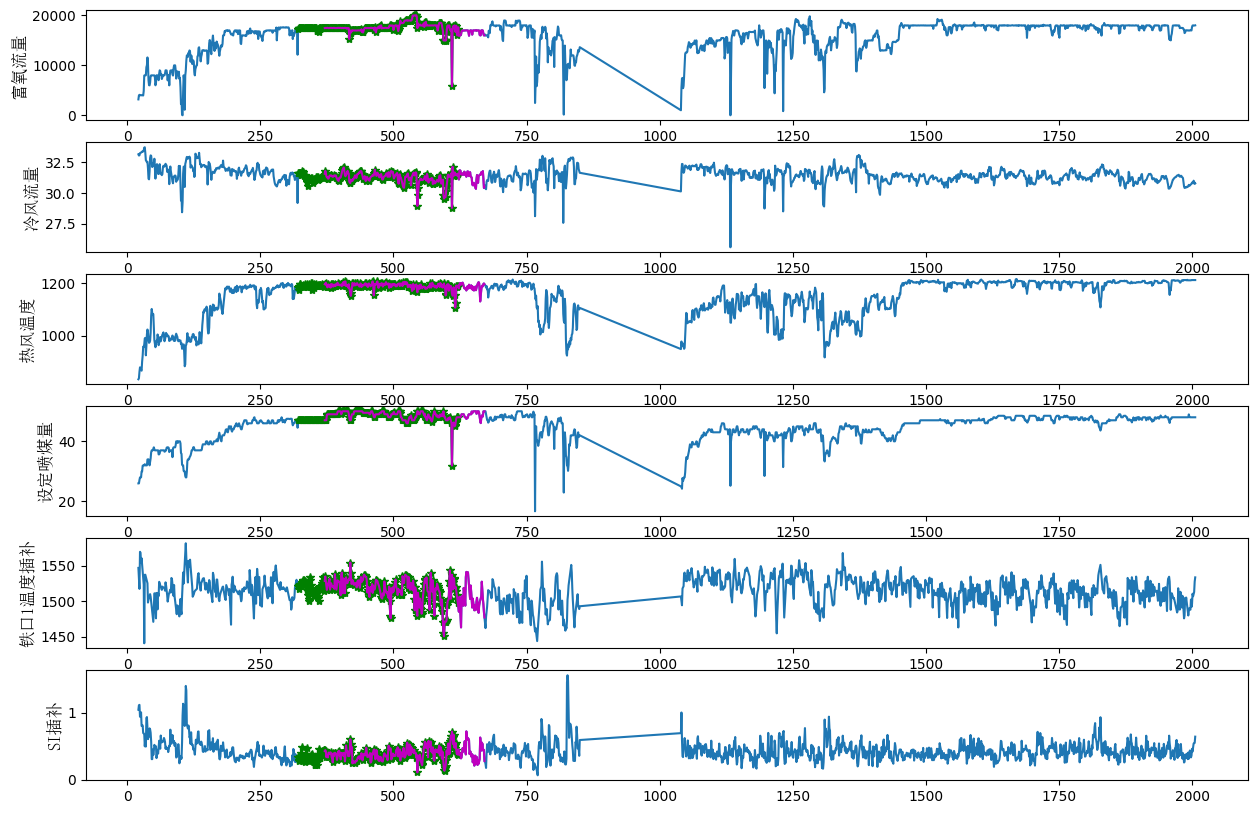

In [51]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'g*-')
    plt.plot(data_x[index_predict],data_y[index_predict],'m-')
    
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签


# index = range(1300, 2500, 1)
# index = range(4500, 6550, 1)

# index = range(5000, 5610, 1)
    
# length = 3000
# start1 = 200
# start2 = 4000   829

length1 = 300
start1 = 350
length2 = 300
start2 = 300


# length = 280
# start1 = 3550
# start2 = 4000
index_predict   = range(start1, start1+length1+1, 1)
index_gaolu     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [52]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_process[input_term[0]].values,
    input_term[1]:   df_sheet_process[input_term[1]].values,
    input_term[2]:   df_sheet_process[input_term[2]].values,
    input_term[3]:   df_sheet_process[input_term[3]].values,
    output_term[0]:  df_sheet_process[output_term[0]].values,
    output_term[1]:  df_sheet_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [53]:
# 组合训练数据--拆分训练、测试集
test_size = 0.30
def make_data(u1_data,u2_data,u3_data,u4_data,y1_data,y2_data,test_size):
    u1_data = u1_data
    u2_data = u2_data
    u3_data = u3_data
    u4_data = u4_data

    u1_data_1 = np.roll(u1_data, 1)
    u2_data_1 = np.roll(u2_data, 1)
    u3_data_1 = np.roll(u3_data, 1)
    u4_data_1 = np.roll(u4_data, 1)

    y1_data = y1_data
    y2_data = y2_data

    X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1], u3_data  [1:-1], u4_data  [1:-1],
                            u1_data_1[1:-1], u2_data_1[1:-1], u3_data_1[1:-1], u4_data_1[1:-1],
                            y1_data  [1:-1], y2_data  [1:-1])
                        )
    y = np.column_stack((y1_data[2:],y2_data[2:]))

    # 使用 reshape 转换形状(457, 10) (457, 2)--->(457, 1, 10) (457, 1, 2)
    # X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    # y_reshaped = y.reshape((y.shape[0], 1, y.shape[1]))
    X_reshaped = X
    y_reshaped = y



    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=True)
                                                        # shuffle=False)


    # print(X_reshaped)
    # print('gggggggg')
    # print(X_train)
    # print(X_test)
    # print('gggggggg')
    # print(y_reshaped)
    # print('gggggggg')
    # print(y_train)
    # print(y_test)

    # y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
    # y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
    
    print(X_train.shape,y_train.shape)
    print(X_test.shape,y_test.shape)

    return X_train, X_test, y_train, y_test ,X_reshaped, y_reshaped


In [54]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
y2_data = normalized_data_dict[output_term[1]][index_gaolu]
num_samples = y2_data.shape[0]


# print('Oxygen_enrich_rate:', u1_data.shape)
# print('Set_coal_amount:', u2_data.shape)
# print('hot_wind_temp:', u3_data.shape)
# print('hot_wind_presure:', u4_data.shape)
# print('temp:', y1_data.shape)
# print('Si_percent:', y2_data.shape)
# print(num_samples)

X_gaolu_train, X_gaolu_test,\
y_gaolu_train, y_gaolu_test ,X_reshaped, y_reshaped = make_data(u1_data,u2_data,u3_data,u4_data,y1_data,y2_data,
                                        test_size=test_size)



(209, 10) (209, 2)
(90, 10) (90, 2)


In [55]:
# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]][index_predict]
u2_data = normalized_data_dict[input_term[1]][index_predict]
u3_data = normalized_data_dict[input_term[2]][index_predict]
u4_data = normalized_data_dict[input_term[3]][index_predict]
y1_data = normalized_data_dict[output_term[0]][index_predict]
y2_data = normalized_data_dict[output_term[1]][index_predict]
num_samples = y2_data.shape[0]


# print('Oxygen_enrich_rate:', u1_data.shape)
# print('Set_coal_amount:', u2_data.shape)
# print('hot_wind_temp:', u3_data.shape)
# print('hot_wind_presure:', u4_data.shape)
# print('temp:', y1_data.shape)
# print('Si_percent:', y2_data.shape)
# print(num_samples)

X_predict_train, X_predict_test,\
y_predict_train, y_predict_test ,X_reshaped, y_reshaped = make_data(u1_data,u2_data,u3_data,u4_data,y1_data,y2_data,
                                        test_size=test_size)


(209, 10) (209, 2)
(90, 10) (90, 2)


In [56]:
# 获取模型参数
def get_params(W_b):

    mid_indix = W_b.shape[0]//2-1
    pred_0 = W_b[-2:-1]
    W0 = W_b[:mid_indix]
    b1 = W_b[-1:]
    W1 = W_b[mid_indix:mid_indix*2]
    W_b_0 = np.concatenate((W0, pred_0))
    W_b_1 = np.concatenate((W1, b1))
    # print(mid_indix)

    # print('pred_0:',pred_0.shape)
    # print('W0:',W0.shape)
    # print('b1:',b1.shape)
    # print('W1:',W1.shape)
    return pred_0,W0,b1,W1,W_b_0,W_b_1


In [57]:
# 定义My_LS_SVRModel
class My_M_LS_SVRModel:
    def __init__(self, params):
        C0, C1, C00, gamma= params
        self.C0 = C0
        self.C1 = C1
        self.C00 = C00
        self.gamma = gamma
        self.W_b = None
        self.X_train = None

    def model_train(self, X_train, y_train, K_train):
        def objective(W_b, X, y):
            b0,W0,b1,W1,W_b_0,W_b_1 = get_params(W_b)

            y_pred_0 = np.dot(K_train, W0) + b0
            y_pred_1 = np.dot(K_train, W1) + b1
            errors0 = y[:,0] - y_pred_0
            errors1 = y[:,1] - y_pred_1

            # 损失函数
            loss = ( 0.5 * (np.dot(W0, W0)+np.dot(W1, W1)) 
                    + self.C0 * np.sum(errors0**2) + self.C1 * np.sum(errors1**2)
                    # + C00 * np.sum(np.sqrt(errors0**2 + errors1**2)) # L2 范数
                    + self.C00 * np.sum(errors0**2 + errors1**2) # L2 范数的平方
                    )
            return loss

        # 初始化权重向量+偏移项b
        initial_W_b = np.zeros((X_train.shape[0])*2+(1)*2)

        # 使用minimize 函数最小化目标函数
        result = minimize(objective, initial_W_b, args=(X_train, y_train),
                            method='L-BFGS-B')
        # 输出最优的权重向量
        best_W_b = result.x
        return best_W_b

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        self.W_b = self.model_train(X_train, y_train, K_train)

    def predict(self, X_test):
        b0,W0,b1,W1,W_b_0,W_b_1 = get_params(self.W_b)
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        y_pred_0 = np.dot(K_test, W0) + b0
        y_pred_1 = np.dot(K_test, W1) + b1
        return y_pred_0, y_pred_1
    


    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_svr_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_svr_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_svr_model.predict(X_test)


In [58]:
# 粒子群参数设置
Particle_num = 2
iterations_max=2


iteration 0
i 0 mse 0.2042825419563947 position [37.16607445 64.50300903 59.62248126 28.86440006]
i 1 mse 0.21664910582135066 position [67.42256504 99.41904539  5.3541621  50.56509672]
[37.16607445 64.50300903 59.62248126 28.86440006] 0.2042825419563947
iteration 1
i 0 mse 0.2057594721695023 position [36.85936362 64.71391527 60.13029022 29.09798157]
i 1 mse 0.21917203324303938 position [66.42256504 98.41904539  6.3541621  49.56509672]
[37.16607445 64.50300903 59.62248126 28.86440006] 0.2042825419563947
Global Best Position and Fitness: [37.16607445 64.50300903 59.62248126 28.86440006]  0.2042825419563947


<Figure size 1000x600 with 0 Axes>

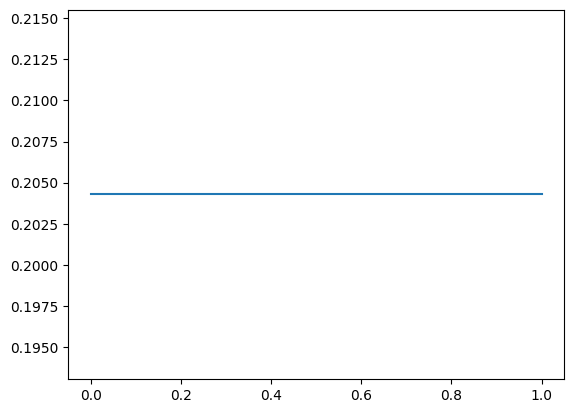

<Figure size 1000x600 with 0 Axes>

In [59]:
# 粒子群优化
def initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax):
    # 初始化粒子群的位置和速度
    positions = np.random.uniform(Xmin, Xmax, size=(Particle_num, params_num))
    # plt.plot(positions[:,0],positions[:,1])
    velocities = np.random.uniform(Vmin, Vmax, size=(Particle_num, params_num))
    return positions, velocities
def evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test):
    # 在这里计算适应值（均方根误差）
    fitness_values = your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test)
    return fitness_values
def update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values):
    # 对每个粒子进行循环
    for i in range(len(positions)):
        # 如果当前适应值更好，则更新个体最佳位置和适应值
        if fitness_values[i] < personal_best_fitness[i]:
            personal_best_positions[i] = positions[i].copy()
            personal_best_fitness[i] = fitness_values[i]
    return personal_best_positions, personal_best_fitness
def update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness):
    # 找到所有粒子中适应值最好的粒子的索引
    best_particle_index = np.argmin(personal_best_fitness)
    # 如果该粒子的适应值更好，则更新全局最佳位置和适应值
    if personal_best_fitness[best_particle_index] < global_best_fitness:
        global_best_position[:] = personal_best_positions[best_particle_index].copy()
        global_best_fitness = personal_best_fitness[best_particle_index]
    return global_best_position,global_best_fitness
def update_particles(iteration, iterations_max, positions, velocities, personal_best_positions, global_best_position, 
                    c1, c2, Xmin, Xmax, Vmin, Vmax):
    # 更新粒子的速度和位置
    r1 = np.random.rand(*positions.shape)
    r2 = np.random.rand(*positions.shape)
    
    w_max = 0.9
    w_min = 0.4
    weight = w_max - iteration*(w_max-w_min)/iterations_max
    # weight = 1
    velocities = weight * velocities + c1 * r1 * (personal_best_positions - positions) + c2 * r2 * (global_best_position - positions)
    # 限制速度范围
    velocities = np.clip(velocities, Vmin, Vmax)
    # 更新位置
    positions = positions + velocities
    # 限制位置范围
    positions = np.clip(positions, Xmin, Xmax)

    return positions, velocities
def pso_algorithm(Particle_num, Xmin, Xmax, Vmin, Vmax, iterations_max, params_num, C1, C2, tao, X_train, y_train, X_test, y_test):
    # 初始化粒子群
    positions, velocities = initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax)

    # 初始化每个粒子的个体最佳位置和适应值
    personal_best_positions = positions.copy()
    personal_best_fitness = np.full(Particle_num, np.inf)#所有元素的值都设置为正无穷
    
    # 初始化全局最佳位置和适应值
    global_best_position = np.zeros(params_num)
    global_best_fitness = np.inf

    fitness_values = np.zeros(Particle_num)
    # 开始迭代
    fitness_values_list = []  # 用于存储每次迭代后的最佳适应值
    for iteration in range(iterations_max):
        print('iteration',iteration)
        # 计算每个粒子的适应值
        fitness_values = evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test)
        
        # 更新个体最佳位置和适应值
        personal_best_positions, personal_best_fitness = update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values)
        
        # 更新全局最佳位置和适应值
        global_best_position,global_best_fitness = update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness)
        print(global_best_position,global_best_fitness)
        # 更新粒子的速度和位置
        positions, velocities = update_particles(iteration, iterations_max,positions, velocities, personal_best_positions, global_best_position, C1, C2, Xmin, Xmax, Vmin, Vmax)
        
        # 记录适应度值
        fitness_values_list.append(global_best_fitness)
        
        # 检查收敛精度
        if global_best_fitness < tao:
            break

    # 返回最终的全局最佳位置和适应值
    return global_best_position, global_best_fitness, fitness_values_list
# 替换为你实际的目标函数
def your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test):
    for i in range(len(positions)):
        # 示例用法
        params = positions[i]
        # 创建模型
        my_svr_model = My_M_LS_SVRModel(params=params)
        # 训练模型
        my_svr_model.fit(X_train, y_train)
        # 模型预测
        y_pred_0, y_pred_1 = my_svr_model.predict(X_test)        
        # 在这里计算适应值（均方根误差）
        errors0 = y_test[:,0] - y_pred_0
        errors1 = y_test[:,1] - y_pred_1
        mse = np.sqrt(np.sum(errors0**2+errors1**2)/X_test.shape[0])
        fitness_values[i] = mse

        print('i',i,"mse",mse,"position",params)
    return fitness_values



# position = [C0, C1, C00, gamma]
# 调用粒子群算法
vel = 1
Xmin = [0]
Xmax = [100]
result_position, result_fitness, fitness_values_list = pso_algorithm(Particle_num = Particle_num, Xmin=Xmin, Xmax=Xmax, Vmin=-vel, Vmax=vel, 
                                                iterations_max = iterations_max, params_num = 4, C1=2, C2=2, tao=0.0001, 
                                                X_train=X_predict_train, y_train=y_predict_train, X_test=X_predict_test, y_test=y_predict_test)

# 输出结果
print(f"Global Best Position and Fitness: {result_position}  {result_fitness}")

plt.plot(fitness_values_list)
plt.figure(figsize=(10, 6))  


Global Best Position and Fitness: [37.16607445 64.50300903 59.62248126 28.86440006]  0.2042825419563947


<Figure size 1000x600 with 0 Axes>

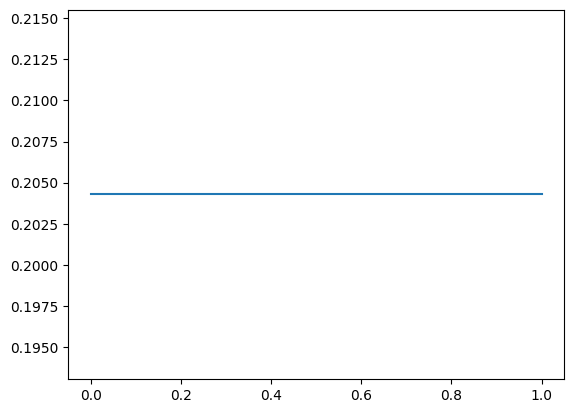

<Figure size 1000x600 with 0 Axes>

In [60]:
# 优化曲线
print(f"Global Best Position and Fitness: {result_position}  {result_fitness}")



# plt.plot(fitness_values_list, label='fitness_values')
# plt.xlabel('iteration Index')
# plt.ylabel('Value')
# plt.legend()


plt.plot(fitness_values_list)
plt.figure(figsize=(10, 6))  


In [61]:
# 创建模[64.08888539 ,50.6098156 , 11.814019  , 24.55465953]
params =   result_position
my_svr_model = My_M_LS_SVRModel(params=params)
# 训练模型
my_svr_model.fit(X_predict_train, y_predict_train)



RMSE: 铁口1温度插补: 8.0123, SI插补: 0.0721
MRE : 铁口1温度插补: 0.0039, SI插补: 0.1498
MAPE: 铁口1温度插补: 0.3911%
MAPE: SI插补: 14.9800%


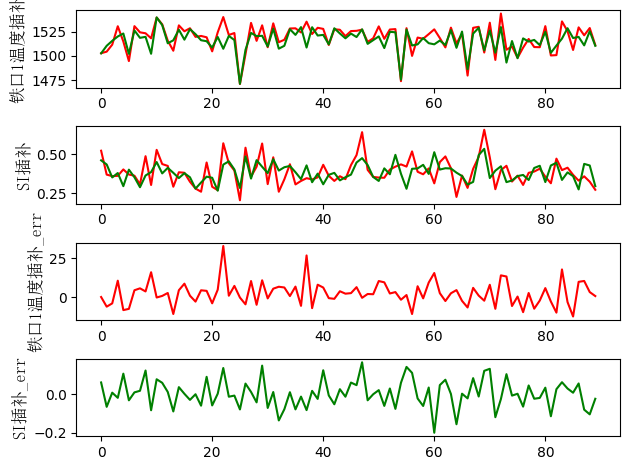

In [ ]:
# 高炉模型预测
y_pred_0, y_pred_1 = my_svr_model.predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test
# y_test = y_test[:70]
# y_pred_0 = y_pred_0[:70]
# y_pred_1 = y_pred_1[:70]

y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))

# 打印结果
# print(f"输出0: RMSE: {rmse_0:.4f}, MRE: {mre_0:.4f}")
# print(f"输出1: RMSE: {rmse_1:.4f}, MRE: {mre_1:.4f}")
print(f"RMSE: {output_term[0]}: {rmse_0:.4f}, {output_term[1]}: {rmse_1:.4f}")
print(f"MRE : {output_term[0]}: { mre_0:.4f}, {output_term[1]}: { mre_1:.4f}")
mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
print(f"MAPE: {output_term[0]}: {mape_0:.4f}%")

mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100
print(f"MAPE: {output_term[1]}: {mape_1:.4f}%")


# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()

